In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(formatter={'float_kind':'{:f}'.format})

In this doc I rewrite the PMx examples in the RxODE Tutorial Paper (doi:10.1002/psp4.12052) with python ODE toolkits
- Ex1: Simulate a Two Compartment Pharmacokinetic Model with an Indirect Response Pharmacodynamic Model
- Ex2: Simulating with Variability
- Ex3: Simulating Adaptive Dosing in a Typical Patient
- Ex4: Simulating Adaptive Dosing with Variability


In [40]:
class Simulator():
    def __init__(self, model, amount, interval, base_effect, **kwargs):
        self.model       = model
        if isinstance(amount, np.ndarray):
            self.amount = amount
        else:
            self.amount      = np.asarray(amount).reshape((1,))
        
        if isinstance(interval, np.ndarray):
            self.interval = interval
        else:
            self.interval    = np.asarray(interval).reshape((1,))
        self.base_effect = base_effect
        self.params = kwargs
    
    def solve(self, cmt=3):
        t = np.asarray([0])
        C = np.concatenate([[self.amount[0]], np.zeros(cmt-1), [self.base_effect]]).reshape(1, cmt+1)
        params = tuple(self.params.values())
        t1 = 0
        for i in range(len(self.amount)):
            if i == 0:
                P0 = np.concatenate([[self.amount[i]], np.zeros(cmt-1), [self.base_effect]])
                t0 = np.linspace(0, self.interval[i], 360)
            else:
                P0 = C0[-1] + np.concatenate([[self.amount[i]], np.zeros(cmt)])
                t1 = t1 + self.interval[i - 1]
                t2 = t1 + self.interval[i]
                t0 = np.linspace(t1, t2, 360)
            C0 = odeint(self.model, P0, t0, args=params)
            t  = np.concatenate([t, t0])
            C  = np.concatenate([C, C0])
        
        return {
            "time_point": t,
            "conc": C
        }
    
    def __add__(self, other):
        amount = np.concatenate([self.amount, other.amount])
        interval = np.concatenate([self.interval, other.interval])
        new = Simulator(self.model, amount, interval, self.base_effect, **self.params)
        return new

    def __mul__(self, num):
        amount = np.repeat(self.amount, num)
        interval = np.repeat(self.interval, num)
        new = Simulator(self.model, amount, interval, self.base_effect, **self.params)
        return new


def mod1(P, t, KA, CL, V2, Q, V3, Kin, Kout, EC50): # This is the right Model that return correct results
    depot, p2, p3, eff = P
    dd_dt = -KA * depot 
    dc_dt =  KA * depot - CL/V2 * p2  - Q /V2 * p2 + Q /V3 * p3
    dp_dt =                         Q / V2 * p2 - Q / V3 * p3 
    de_dt = Kin - Kout * (1 - p2/V2 / (EC50 + p2/V2)) * eff
    return [dd_dt, dc_dt, dp_dt, de_dt]

# specify parameters
theta = {
    "KA":0.294, "CL": 18.6, "V2": 40.2, # central
    "Q": 10.5,  "V3": 297,                # peripheral
    "Kin": 1, "Kout": 1, "EC50": 200             # effects
}

base = Simulator(mod1, amount=10000, interval=12, base_effect=1, **theta)
print(base.solve()['conc'][1:15,2]/297)

[0.000000 0.001428 0.005644 0.012552 0.022055 0.034063 0.048485 0.065234
 0.084225 0.105375 0.128605 0.153835 0.180991 0.209998]


# Two Compartment PK Model with Indirect Response PD Model (Multiple Doses)

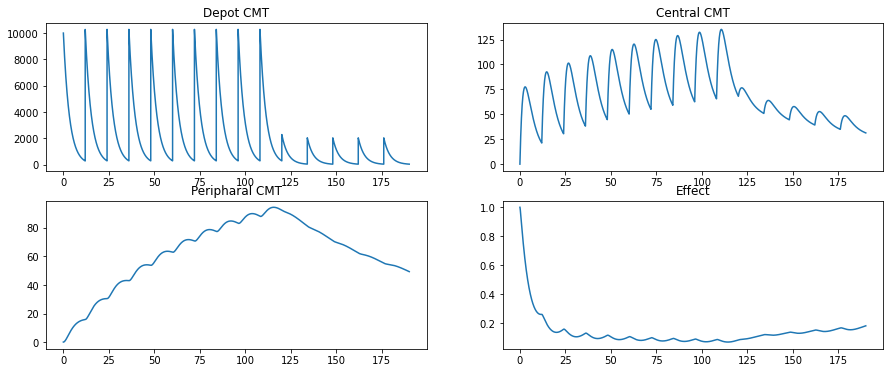

In [2]:
class Simulator():
    def __init__(self, model, amount, interval, base_effect, **kwargs):
        self.model       = model
        if isinstance(amount, np.ndarray):
            self.amount = amount
        else:
            self.amount      = np.asarray(amount).reshape((1,))
        
        if isinstance(interval, np.ndarray):
            self.interval = interval
        else:
            self.interval    = np.asarray(interval).reshape((1,))
        self.base_effect = base_effect
        self.params = kwargs
    
    def solve(self, cmt=3):
        t = np.asarray([0])
        C = np.concatenate([[self.amount[0]], np.zeros(cmt-1), [self.base_effect]]).reshape(1, cmt+1)
        params = tuple(self.params.values())
        t1 = 0
        for i in range(len(self.amount)):
            if i == 0:
                P0 = np.concatenate([[self.amount[i]], np.zeros(cmt-1), [self.base_effect]])
                t0 = np.linspace(0, self.interval[i], 360)
            else:
                P0 = C0[-1] + np.concatenate([[self.amount[i]], np.zeros(cmt)])
                t1 = t1 + self.interval[i - 1]
                t2 = t1 + self.interval[i]
                t0 = np.linspace(t1, t2, 360)
            C0 = odeint(self.model, P0, t0, args=params)
            t  = np.concatenate([t, t0])
            C  = np.concatenate([C, C0])
        
        return {
            "time_point": t,
            "conc": C
        }
    
    def __add__(self, other):
        amount = np.concatenate([self.amount, other.amount])
        interval = np.concatenate([self.interval, other.interval])
        new = Simulator(self.model, amount, interval, self.base_effect, **self.params)
        return new

    def __mul__(self, num):
        amount = np.repeat(self.amount, num)
        interval = np.repeat(self.interval, num)
        new = Simulator(self.model, amount, interval, self.base_effect, **self.params)
        return new

# define the model
def mod1(P, t, KA, CL, V2, Q, V3, Kin, Kout, EC50): # This is the right Model that return correct results
    depot, p2, p3, eff = P
    dd_dt = -KA * depot 
    dc_dt =  KA * depot - CL/V2 * p2  - Q /V2 * p2 + Q /V3 * p3
    dp_dt =                         Q / V2 * p2 - Q / V3 * p3 
    de_dt = Kin * (1 - p2/V2 / (EC50 + p2/V2)) - Kout * eff
    return [dd_dt, dc_dt, dp_dt, de_dt]

# specify parameters
theta = {
    "KA":0.3, "CL": 7, "V2": 40, # central
    "Q": 10,  "V3": 300,                # peripheral
    "Kin": 0.2, "Kout": 0.2, "EC50": 8            # effects
}

# 10mg BID for 5d: amount=10, interval=12, num_doses=10

# followed by 20mg QD for 5d: amount=2, interval=14, num_doses=5

base = Simulator(mod1, amount=10000, interval=12, base_effect=1, **theta)
ms1 = Simulator(mod1, amount=10000, interval=12, base_effect=1, **theta)
ms2 = Simulator(mod1, amount=2000, interval=14, base_effect=1, **theta)
# ms3 = Simulator(mod1, amount=2000, interval=64, base_effect=1, **theta)

reg = base + ms1 * 9 + ms2 * 5

res = reg.solve()

_, ax = plt.subplots(2,2, figsize=(15,6))
ax[0,0].plot(res['time_point'], res['conc'][:,0])
ax[0,0].set_title("Depot CMT")

ax[0,1].plot(res['time_point'], res['conc'][:,1]/ theta['V2'])
ax[0,1].set_title("Central CMT")

ax[1,0].plot(res['time_point'], res['conc'][:,2]/ theta['V3'])
ax[1,0].set_title("Peripharal CMT")

ax[1,1].plot(res['time_point'], res['conc'][:,3])
ax[1,1].set_title("Effect")
plt.show()

In [48]:
res['conc'][0:361:30,]

array([[10000.000000, 0.000000, 0.000000, 1.000000],
       [7476.593648, 2050.545053, 276.848891, 1.137662],
       [5534.170216, 2919.937304, 900.166817, 1.310855],
       [4096.389535, 3099.926247, 1622.704627, 1.484797],
       [3032.145120, 2936.006221, 2317.960455, 1.655308],
       [2244.392031, 2623.999996, 2928.657568, 1.819900],
       [1661.297660, 2270.518824, 3435.664647, 1.976329],
       [1229.691550, 1929.945361, 3839.706307, 2.122327],
       [910.216961, 1626.836528, 4150.842885, 2.255617],
       [673.742059, 1369.325021, 4382.614139, 2.374052],
       [498.703476, 1157.003379, 4548.939980, 2.475828],
       [369.140020, 985.457209, 4662.616983, 2.559716],
       [273.237226, 848.787208, 4734.711371, 2.625246]])

# Simulating With Variability

In [59]:
KA = np.repeat(0.3, 100).reshape(100,1)
Q = np.repeat(10, 100).reshape(100,1)
V3 = np.repeat(300, 100).reshape(100,1)
Kin = np.repeat(0.2, 100).reshape(100,1)
Kout = np.repeat(0.2, 100).reshape(100,1)
EC50 = np.repeat(8, 100).reshape(100,1)

m = [0, 0]
cov = np.array([[0.09, 0.09],[0.08, 0.25]])
cl_v2 = np.exp(np.random.multivariate_normal(m, cov, 100)) * [7, 40]

theta = np.concatenate([KA, cl_v2, Q, V3, Kin, Kout, EC50], axis=1)

theta[0:6,]

/var/folders/cb/pxnfxyts32n8rdq49q4djgs80000gn/T/ipykernel_20096/2103274196.py:10: RuntimeWarning: covariance is not positive-semidefinite.
  cl_v2 = np.exp(np.random.multivariate_normal(m, cov, 100)) * [7, 40]


array([[0.300000, 8.449103, 53.922339, 10.000000, 300.000000, 0.200000,
        0.200000, 8.000000],
       [0.300000, 11.023913, 39.036149, 10.000000, 300.000000, 0.200000,
        0.200000, 8.000000],
       [0.300000, 8.403712, 55.915231, 10.000000, 300.000000, 0.200000,
        0.200000, 8.000000],
       [0.300000, 11.068761, 64.550696, 10.000000, 300.000000, 0.200000,
        0.200000, 8.000000],
       [0.300000, 8.408408, 74.517504, 10.000000, 300.000000, 0.200000,
        0.200000, 8.000000],
       [0.300000, 9.115866, 44.075695, 10.000000, 300.000000, 0.200000,
        0.200000, 8.000000]])

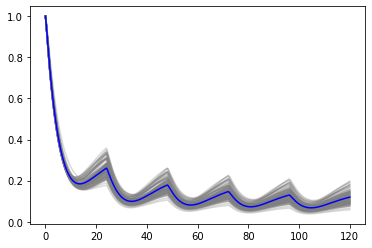

In [60]:
class Simulator():
    def __init__(self, model, amount, interval, base_effect, params):
        self.model       = model
        if isinstance(amount, np.ndarray):
            self.amount = amount
        else:
            self.amount      = np.asarray(amount).reshape((1,))
        
        if isinstance(interval, np.ndarray):
            self.interval = interval
        else:
            self.interval    = np.asarray(interval).reshape((1,))
        self.base_effect = base_effect
        self.params = params
    
    def solve(self, cmt=3):
        t = np.asarray([0])
        C = np.concatenate([[self.amount[0]], np.zeros(cmt-1), [self.base_effect]]).reshape(1, cmt+1)
        params = tuple(self.params)
        t1 = 0
        for i in range(len(self.amount)):
            if i == 0:
                P0 = np.concatenate([[self.amount[i]], np.zeros(cmt-1), [self.base_effect]])
                t0 = np.linspace(0, self.interval[i], 360)
            else:
                P0 = C0[-1] + np.concatenate([[self.amount[i]], np.zeros(cmt)])
                t1 = t1 + self.interval[i - 1]
                t2 = t1 + self.interval[i]
                t0 = np.linspace(t1, t2, 360)
            C0 = odeint(self.model, P0, t0, args=params)
            t  = np.concatenate([t, t0])
            C  = np.concatenate([C, C0])
        
        return {
            "time_point": t,
            "conc": C
        }
    
    def __add__(self, other):
        amount = np.concatenate([self.amount, other.amount])
        interval = np.concatenate([self.interval, other.interval])
        new = Simulator(self.model, amount, interval, self.base_effect, self.params)
        return new

    def __mul__(self, num):
        amount = np.repeat(self.amount, num)
        interval = np.repeat(self.interval, num)
        new = Simulator(self.model, amount, interval, self.base_effect, self.params)
        return new


# define the model
def mod1(P, t, KA, CL, V2, Q, V3, Kin, Kout, EC50): # This is the right Model that return correct results
    depot, p2, p3, eff = P
    dd_dt = -KA * depot 
    dc_dt =  KA * depot - CL/V2 * p2  - Q /V2 * p2 + Q /V3 * p3
    dp_dt =                         Q / V2 * p2 - Q / V3 * p3 
    de_dt = Kin * (1 - p2/V2 / (EC50 + p2/V2)) - Kout * eff
    return [dd_dt, dc_dt, dp_dt, de_dt]


res = []
for i in range(100):
    base = Simulator(mod1, amount=20000, interval=24, base_effect=1, params=theta[i])
    regimen = base*5
    res.append(regimen.solve()['conc'][:,3])
    plt.plot(regimen.solve()['time_point'], res[i], 'grey', alpha=0.3)

plt.plot(regimen.solve()['time_point'], np.asarray(res).mean(axis=0), 'blue')

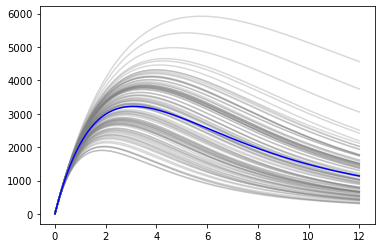

In [61]:
res = []
for i in range(100):
    base = Simulator(mod1, amount=10000, interval=12, base_effect=1, params=theta[i])
    res.append(base.solve()['conc'][:,1])
t = base.solve()['time_point']

for i in range(100):
    plt.plot(t, res[i], 'grey', alpha=0.3)
plt.plot(t, np.asarray(res).mean(axis=0), 'blue')

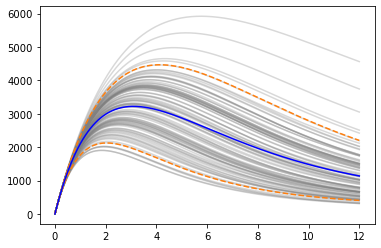

In [65]:
res = []
for i in range(100):
    base = Simulator(mod1, amount=10000, interval=12, base_effect=1, params=theta[i])
    res.append(base.solve()['conc'][:,1])
t = base.solve()['time_point']

for i in range(100):
    plt.plot(t, res[i], 'grey', alpha=0.3)
plt.plot(t, np.quantile(res, 0.05, axis=0), 'C1--')
plt.plot(t, np.quantile(res, 0.95, axis=0), 'C1--')
plt.plot(t, np.asarray(res).mean(axis=0), 'blue')

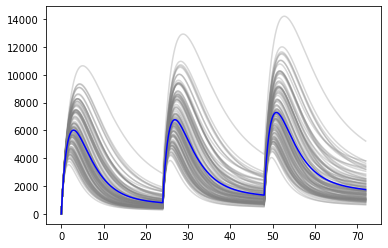

In [7]:
res = []
for i in range(100):
    base = Simulator(mod1, amount=20000, interval=24, base_effect=1, params=theta[i])
    regimen = base*3
    res.append(regimen.solve()['conc'][:,1])
    plt.plot(regimen.solve()['time_point'], res[i], 'grey', alpha=0.3)

plt.plot(regimen.solve()['time_point'], np.asarray(res).mean(axis=0), 'blue')

# Simulating Adaptive Dosing in a Typical Patient
DECISION RULE
- Dosed QD
- Monitor **trough PD effect** levels (24h after dosing)
- Target range for effect: 40-60%
- effect < 40%, double the dose
- effect > 60%, cut the dose in half 

In [66]:
class Simulator():
    def __init__(self, model, amount, interval, base_effect, params):
        self.model       = model
        if isinstance(amount, np.ndarray):
            self.amount = amount
        else:
            self.amount      = np.asarray(amount).reshape((1,))
        
        if isinstance(interval, np.ndarray):
            self.interval = interval
        else:
            self.interval    = np.asarray(interval).reshape((1,))
        self.base_effect = base_effect
        self.params = params
    
    def solve(self, cmt=3):
        t = np.asarray([0])
        C = np.concatenate([[self.amount[0]], np.zeros(cmt-1), [self.base_effect]]).reshape(1, cmt+1)
        Emax = []
        params = tuple(self.params)
        t1 = 0
        for i in range(len(self.amount)):
            if i == 0:
                P0 = np.concatenate([[self.amount[i]], np.zeros(cmt-1), [self.base_effect]])
                t0 = np.linspace(0, self.interval[i], 360)
            else:
                P0 = C0[-1] + np.concatenate([[self.amount[i]], np.zeros(cmt)])
                t1 = t1 + self.interval[i - 1]
                t2 = t1 + self.interval[i]
                t0 = np.linspace(t1, t2, 360)
            C0 = odeint(self.model, P0, t0, args=params)
            Emax.append(C0[:,-1].min())

            t  = np.concatenate([t, t0])
            C  = np.concatenate([C, C0])
        
        return {
            "time_point": t,
            "conc": C,
            "emax": Emax
        }
    
    def __add__(self, other):
        amount = np.concatenate([self.amount, other.amount])
        interval = np.concatenate([self.interval, other.interval])
        new = Simulator(self.model, amount, interval, self.base_effect, self.params)
        return new

    def __mul__(self, num):
        amount = np.repeat(self.amount, num)
        interval = np.repeat(self.interval, num)
        new = Simulator(self.model, amount, interval, self.base_effect, self.params)
        return new


# define the model
def mod1(P, t, KA, CL, V2, Q, V3, Kin, Kout, EC50): # This is the right Model that return correct results
    depot, p2, p3, eff = P
    dd_dt = -KA * depot 
    dc_dt =  KA * depot - CL/V2 * p2  - Q /V2 * p2 + Q /V3 * p3
    dp_dt =                         Q / V2 * p2 - Q / V3 * p3 
    de_dt = Kin * (1 - p2/V2 / (EC50 + p2/V2)) - Kout * eff
    return [dd_dt, dc_dt, dp_dt, de_dt]

theta = {
    "KA":0.3, "CL": 7, "V2": 40, # central
    "Q": 10,  "V3": 300,                # peripheral
    "Kin": 0.2, "Kout": 0.2, "EC50": 8            # effects
}

theta = [i for i in theta.values()]
theta

[0.3, 7, 40, 10, 300, 0.2, 0.2, 8]

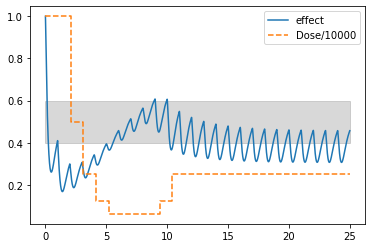

In [67]:
# Decision Rule Limits
effect_limits = [0, 0.4, 0.6, 9]
# Decision Rule Effect
dose_multipliers = [0.5, 1, 2]
ndays = 25

base = Simulator(mod1, amount=10000, interval=24, base_effect=1, params=theta)
ms1 = Simulator(mod1, amount=10000, interval=24, base_effect=1, params=theta)

res = ms1.solve()
for i in range(1,25):
    #print(i)
    if res['conc'][-1, -1] < 0.4:
        base.amount = ms1.amount[-1, np.newaxis] * 0.5
    elif res['conc'][-1, -1] >0.6:
        base.amount = ms1.amount[-1, np.newaxis] * 2
    else:
        base.amount = ms1.amount[-1, np.newaxis]
    ms1 = ms1 + base
    #print(ms1.amount)
    res = ms1.solve()
    #print(res['conc'][-1])

plt.plot(res['time_point']/24, res['conc'][:,-1], label='effect')
plt.fill_between(x=[0,25], y1=0.4, y2=0.6, color='grey', alpha=0.3)

x = np.linspace(0, 25, 25)
plt.step(x, ms1.amount/10000, 'C1--', where='post', label='Dose/10000')

plt.legend()
plt.show()

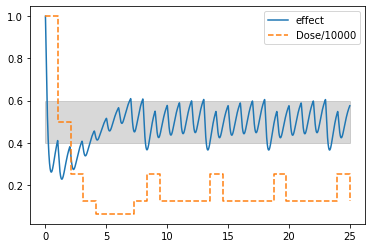

In [68]:
# Decision Rule Limits
effect_limits = [0, 0.4, 0.6, 9]
# Decision Rule Effect
dose_multipliers = [0.5, 1, 2]
ndays = 25

base = Simulator(mod1, amount=10000, interval=24, base_effect=1, params=theta)
ms1 = Simulator(mod1, amount=10000, interval=24, base_effect=1, params=theta)

res = ms1.solve()
for i in range(1,25):
    #print(i)
    if res['emax'][-1] < 0.4:
        base.amount = ms1.amount[-1, np.newaxis] * 0.5
    elif res['conc'][-1, -1] < 0.4:
        base.amount = ms1.amount[-1, np.newaxis] * 0.5
    elif res['conc'][-1, -1] >0.6:
        base.amount = ms1.amount[-1, np.newaxis] * 2
    else:
        base.amount = ms1.amount[-1, np.newaxis]
    ms1 = ms1 + base
    #print(ms1.amount)
    res = ms1.solve()
    #print(res['conc'][-1])

plt.plot(res['time_point']/24, res['conc'][:,-1], label='effect')
plt.fill_between(x=[0,25], y1=0.4, y2=0.6, color='grey', alpha=0.3)

x = np.linspace(0, 25, 25)
plt.step(x, ms1.amount/10000, 'C1--', where='post', label='Dose/10000')

plt.legend()
plt.show()

# Simulating Adaptive Dosing with Variability

In [69]:
KA = np.repeat(0.3, 100).reshape(100,1)
Q = np.repeat(10, 100).reshape(100,1)
V3 = np.repeat(300, 100).reshape(100,1)
Kin = np.repeat(0.2, 100).reshape(100,1)
Kout = np.repeat(0.2, 100).reshape(100,1)
EC50 = np.repeat(8, 100).reshape(100,1)

m = [0, 0]
cov = np.array([[0.09, 0.09],[0.08, 0.25]])
cl_v2 = np.exp(np.random.multivariate_normal(m, cov, 100)) * [7, 40]

theta = np.concatenate([KA, cl_v2, Q, V3, Kin, Kout, EC50], axis=1)

/var/folders/cb/pxnfxyts32n8rdq49q4djgs80000gn/T/ipykernel_20096/2500851992.py:10: RuntimeWarning: covariance is not positive-semidefinite.
  cl_v2 = np.exp(np.random.multivariate_normal(m, cov, 100)) * [7, 40]


In [87]:
regimen = []
dose = []
for i in range(100):
    base = Simulator(mod1, amount=10000, interval=24, base_effect=1, params=theta[i])
    ms1 = Simulator(mod1, amount=10000, interval=24, base_effect=1, params=theta[i])

    res = ms1.solve()
    for j in range(1,25):
        #print(i)
        if res['conc'][-1, -1] < 0.4:
            base.amount = ms1.amount[-1, np.newaxis] * 0.5
        elif res['conc'][-1, -1] >0.6:
            base.amount = ms1.amount[-1, np.newaxis] * 2
        else:
            base.amount = ms1.amount[-1, np.newaxis]
        ms1 = ms1 + base
        #print(ms1.amount)
        res = ms1.solve()
    regimen.append(res['conc'][:,-1])
    dose.append(ms1.amount)
#     plt.plot(regimen.solve()['time_point'], res[i], 'grey', alpha=0.3)

# plt.plot(regimen.solve()['time_point'], np.asarray(res).mean(axis=0), 'blue')

In [78]:
regimen = np.asarray(regimen)

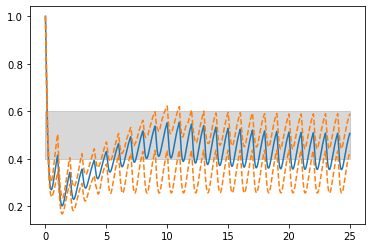

In [86]:

plt.plot(res['time_point']/24, regimen.mean(axis=0))
plt.plot(res['time_point']/24, np.quantile(regimen, 0.05, axis=0), "C1--")
plt.plot(res['time_point']/24, np.quantile(regimen, 0.95, axis=0), "C1--")

plt.fill_between(x=[0,25], y1=0.4, y2=0.6, color='grey', alpha=0.3)

plt.show()

In [89]:
dose = np.asarray(dose)

In [101]:
import pandas as pd
dose_data = pd.DataFrame(dose.T)
dose_data.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
1,5000.0,5000.0,5000.0,5000.0,5000.0,10000.0,10000.0,10000.0,10000.0,5000.0,...,10000.0,5000.0,10000.0,5000.0,5000.0,10000.0,10000.0,5000.0,5000.0,10000.0
2,2500.0,2500.0,2500.0,2500.0,2500.0,5000.0,5000.0,5000.0,5000.0,2500.0,...,5000.0,2500.0,5000.0,2500.0,2500.0,10000.0,5000.0,2500.0,2500.0,5000.0
3,2500.0,1250.0,1250.0,1250.0,1250.0,5000.0,2500.0,2500.0,5000.0,1250.0,...,2500.0,1250.0,5000.0,1250.0,1250.0,5000.0,2500.0,1250.0,1250.0,2500.0
4,2500.0,625.0,625.0,625.0,1250.0,5000.0,1250.0,2500.0,5000.0,625.0,...,1250.0,1250.0,5000.0,1250.0,1250.0,5000.0,1250.0,625.0,1250.0,1250.0


In [126]:
dose_map = dose_data.reset_index().melt(id_vars='index').rename(columns={'value':"dose"}).groupby('index')['dose'].value_counts().unstack()
dose_map

dose,78.125,156.250,312.500,625.000,1250.000,2500.000,5000.000,10000.000
index,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
1,NaN,NaN,NaN,NaN,NaN,NaN,45.0,55.0
2,NaN,NaN,NaN,NaN,NaN,45.0,49.0,6.0
3,NaN,NaN,NaN,NaN,40.0,46.0,14.0,NaN
4,NaN,NaN,NaN,19.0,48.0,21.0,12.0,NaN
5,NaN,NaN,8.0,19.0,40.0,21.0,12.0,NaN
6,NaN,3.0,5.0,19.0,40.0,21.0,12.0,NaN
7,2.0,1.0,5.0,19.0,40.0,21.0,12.0,NaN
8,2.0,1.0,5.0,19.0,40.0,21.0,12.0,NaN


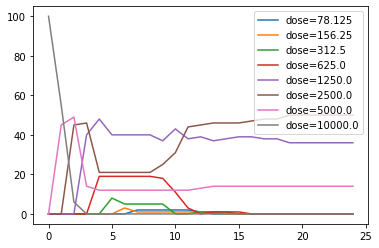

In [139]:
dose_map.fillna(0, inplace=True)

for i in dose_map.columns:
    plt.plot(dose_map.index, dose_map[i], label=f'dose={i}')
plt.legend()
plt.show()